# 📚 PINNs: Neural Network as Solver of the PDE Solution

### 🔍 Neural Network as Solver of the PDE Solution

We set up a neural network model $u_\theta(x,t)$ to approximate the solution $u(x,t) $ of the PDE.  

The key idea is to **learn $u_\theta$ by minimizing the residuals of the PDE and the boundary/initial conditions**, *without* needing the explicit analytical solution of $ u(x, t)$.


This means our training objective is to find the network parameters $\theta $ such that:

- The PDE residual $ \mathcal{R}(x,t) $ is minimized at **collocation points**,
- The network output respects the **initial condition** 
- The network output respects the **boundary conditions** 


To achieve this, we **pass the residual loss functions** we defined earlier:

- $ \mathcal{L}_{\text{PDE}} $ for the PDE residual,
- $ \mathcal{L}_{\text{IC}} $ for the initial condition,
- $ \mathcal{L}_{\text{BC}} $ for the boundary condition,

to an optimizer that minimizes their weighted sum (**the deep learning training process**):

$ \min_{\theta} \ \mathcal{L}(\theta) = \mathcal{L}_{\text{PDE}} + \lambda_{\text{IC}} \mathcal{L}_{\text{IC}} + \lambda_{\text{BC}} \mathcal{L}_{\text{BC}}$

This defines the optimization problem underlying our Physics-Informed Neural Network (PINN) framework.


### Imports and setup

In [1]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(53)
pl.seed_everything(53)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Seed set to 53


Using device: cpu


### 🌐 Define the PDE Domain and Sampling Strategy

In this section, we define the **PDE domain** where our Physics-Informed Neural Network (PINN) will operate.  
We discretize the space-time domain, sample **collocation points** where the PDE will be enforced, and define **boundary** and **initial conditions**.





#### 🧮 Domain $ (x,t) $

We construct a uniform grid in the $(x, t)$ domain:  
- $x \in [-1, 1]$  
- $t \in [0, 1]$  
- Resolution: `Nx` points in space and `Nt` points in time  

This results in a 2D grid of size $ \text{Nx} \times \text{Nt} $.


In [3]:
Nx, Nt = 300, 200
# set grid PDE domain at resolution Nx, Nt
x = np.linspace(-1, 1, Nx)
t = np.linspace(0, 1, Nt)
X, T = np.meshgrid(x, t)
xt_grid = np.stack([X.ravel(), T.ravel()], axis=-1)  # shape (N, 2) where N = Nx * Nt

#### 🔍 Collocation Points

From the full grid, we randomly sample:  
- `Ncp` **collocation points** where the PDE will be enforced  
- These are split into training and validation sets (e.g., 80% / 20%)

In [4]:
def collocation_points_generation(xt_grid, Ncp, val_ratio=0.2):
    # Sample Ncp from grid where to evaluate PDE
    xt_cp = xt_grid[np.random.choice(len(xt_grid), Ncp, replace=False)]
    # Split the data train, val (80-20%)
    train_xt_cp, valid_xt_cp, _, _ = train_test_split(xt_cp, np.zeros(len(xt_cp)), test_size=val_ratio, random_state=52)

    return train_xt_cp, valid_xt_cp

In [5]:
# Generate collocation points
Ncp = 2000 # Number of Collocation points
coll_points_train, coll_points_val = collocation_points_generation(xt_grid, Ncp, val_ratio=0.2)

#### 🧱 Boundary Conditions (BC)

We select `Nbc` points along the **spatial boundaries** $x = -1$ and $x = 1$, across different times.  
We impose homogeneous Dirichlet boundary conditions:

- $u(-1, t) = u(1, t) = 0$


In [6]:
def boundary_condition_points(Nbc, xt_grid):
    # Define Boundary Conditions
    xt_bc = xt_grid[np.argwhere((xt_grid[:, 0] == 1) | (xt_grid[:, 0] == -1)).reshape(-1)]  # all points at x=-1 and x=1
    xt_bc = xt_bc[np.random.choice(len(xt_bc), Nbc, replace=False)]
    u_bc = np.zeros(xt_bc.shape[0]).reshape(-1, 1)  # set bc of u(-1, t) = u(1, t) = 0
    
    return xt_bc, u_bc

In [7]:
# Generate boundary condition points (x,t) and solution u(x,t)
Nbc = 100  # Number of Boundary condition points
xt_bc, u_bc = boundary_condition_points(Nbc, xt_grid)

#### 🧨 Initial Conditions (IC)

We select `Nic` points at the **initial time** $t = 0$, across the entire spatial domain.  
The initial condition is given by:

- $u(x, 0) = -\sin(\pi x)$


In [8]:
def initial_condition_points(Nic, xt_grid):
    # Define Initial  Conditions
    xt_ic = xt_grid[np.argwhere(xt_grid[:, 1] == 0).reshape(-1)]  # All points with t=0
    xt_ic = xt_ic[np.random.choice(len(xt_ic), Nic, replace=False)]
    u_ic = -np.sin(np.pi*xt_ic[:, 0]).reshape(-1, 1)  # set ic u(x, 0) = - sin(pi*x) 

    return xt_ic, u_ic

In [9]:
# Generate initial condition points (x,t) and solution u(x,t)
Nic = 100  # Number Initial condition points
xt_ic, u_ic = initial_condition_points(Nic, xt_grid)

#### 📊 Visualization

The figure below shows:  
- The full space-time  
- Collocation points (training and validation)  
- Boundary condition points (colored by $u$)  
- Initial condition points (colored by $u$)

This setup forms the foundation for training the PINN to solve the PDE.

In [10]:
def plot_collocation_setup(xt_grid, coll_points_train, coll_points_val, xt_bc, u_bc, xt_ic, u_ic):
    plt.figure(figsize=(10, 6))

    plt.scatter(xt_grid[:, 0], xt_grid[:, 1], color='black', alpha=0.15, label='grid', s=1)

    # Plot collocation points
    plt.scatter(coll_points_train[:, 0], coll_points_train[:, 1], color='dodgerblue', s=10, label='Collocation (train)', alpha=0.6)
    plt.scatter(coll_points_val[:, 0], coll_points_val[:, 1], color='orange', s=10, label='Collocation (val)', alpha=0.6)

    # Boundary condition points 
    sc1 = plt.scatter(xt_bc[:, 0], xt_bc[:, 1], c=u_bc.ravel(), cmap='jet', marker='x', s=40, label='Boundary condition')
    # Initial condition points
    sc2 = plt.scatter(xt_ic[:, 0], xt_ic[:, 1], c=u_ic.ravel(), cmap='jet', marker='^', s=40, label='Initial condition')
    # Add a single colorbar (optional)
    cbar = plt.colorbar(sc2)
    cbar.set_label("u(x,t)")

    plt.xlabel('x', fontsize=12)
    plt.ylabel('t', fontsize=12)
    plt.title('PDE Domain and PINN Collocation, Boundary, and Initial Condition Points', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

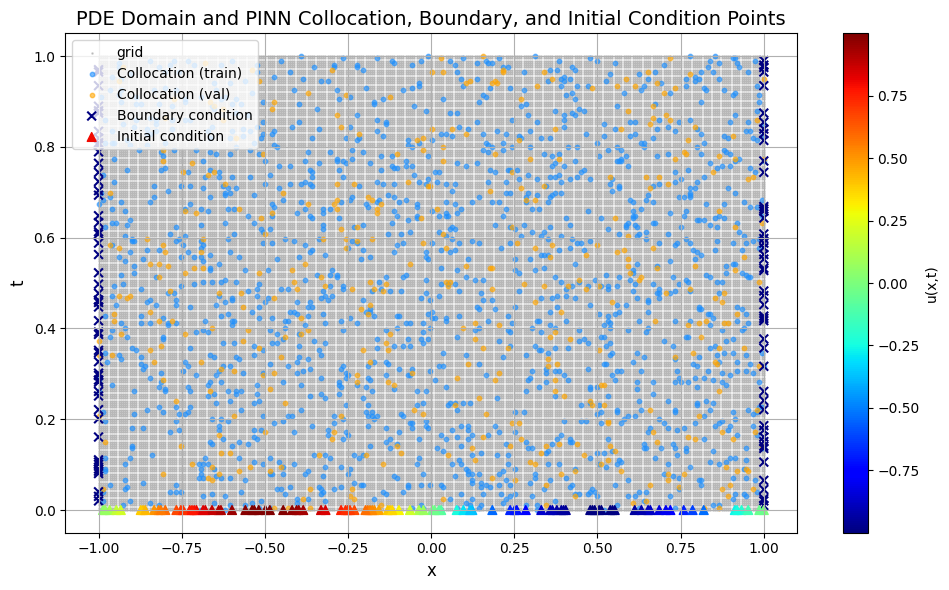

In [11]:
plot_collocation_setup(xt_grid, coll_points_train, coll_points_val, xt_bc, u_bc, xt_ic, u_ic)

### 🧩 PINN Loss Functions: Residuals and Conditions

Our goal is to train a neural network $ u(x,t) $ that satisfies the PDE:

##### $ u_t + u \cdot u_x - \nu u_{xx} = 0 $

where:
- $ u_t = \frac{\partial u}{\partial t} $ (time derivative)  
- $ u_x = \frac{\partial u}{\partial x} $ (spatial derivative)  
- $ u_{xx} = \frac{\partial^2 u}{\partial x^2} $ (second spatial derivative)  
- $ \nu=0.025 $ is the viscosity coefficient.



#### PDE Residual Loss

At **collocation points** $ (x,t) $, the PDE residual should be zero:

$ \mathcal{R}(x,t) = u_t + u u_x - \nu u_{xx} \approx 0 $

The PDE loss minimizes the mean squared residual:

$ \mathcal{L}_{\text{PDE}} = \frac{1}{N_{cp}} \sum_{i=1}^{N_{cp}} \mathcal{R}(x_i, t_i)^2 $


In [12]:
# Physical parameters
nu = 0.025 

def residual_pde(xt_cp, model):
    """
    Compute PDE residual loss at collocation points:
    """
    x = xt_cp[:, 0:1].clone().detach().requires_grad_(True)  # activate gradients
    t = xt_cp[:, 1:].clone().detach().requires_grad_(True)   # activate gradients
    
    with torch.enable_grad():
        inputs = torch.cat([x, t], dim=1)
        u_hat = model(inputs)
        
        # First derivatives
        du_dt = torch.autograd.grad(u_hat, t, grad_outputs=torch.ones_like(u_hat), create_graph=True)[0]
        du_dx = torch.autograd.grad(u_hat, x, grad_outputs=torch.ones_like(u_hat), create_graph=True)[0]
        
        # Second derivative wrt x
        d2u_dx2 = torch.autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

        # PDE residual: u_t + u * u_x - nu * u_xx = 0
        residual = du_dt + u_hat * du_dx - nu * d2u_dx2
        
        residual_pde_ = torch.mean(residual ** 2)
        
    return residual_pde_


#### Initial Condition Residual Loss

At initial time $ t=0 $, the network output must match the initial condition:

$ u(x,0) = u_{\text{ic}}(x) $

The initial condition loss works as a data-driven approach, because the solution $u(x,t)$ is known:

$ \mathcal{L}_{\text{IC}} = \frac{1}{N_{ic}} \sum_{i=1}^{N_{ic}} \left( u(x_i,0) - u_{\text{ic}}(x_i) \right)^2 $


In [13]:
def residual_ic(xt_ic, u_ic, model):
    """
    Compute MSE loss for Initial Condition:
    """
    u_pred = model(xt_ic)
    return torch.mean((u_ic - u_pred) ** 2)

#### Boundary Condition Residual Loss

On spatial boundaries $ x = \pm 1 $, enforce:

$ u(-1, t) = u(1, t) = 0 $

The boundary loss is:

$ \mathcal{L}_{\text{BC}} = \frac{1}{N_{bc}} \sum_{i=1}^{N_{bc}} \left( u(x_i, t_i) - u_{\text{bc}}(x_i, t_i) \right)^2 $

In [14]:
def residual_bc(xt_bc, u_bc, model):
    """
    Compute MSE loss for Boundary Condition:
    """
    u_pred = model(xt_bc)
    return torch.mean((u_pred - u_bc) ** 2)

#### Total Residual to minimize

The total loss is typically a weighted sum:

$
\mathcal{L} = \mathcal{L}_{\text{PDE}} + \lambda_{\text{IC}} \mathcal{L}_{\text{IC}} + \lambda_{\text{BC}} \mathcal{L}_{\text{BC}}
$

which is minimized during training to solve the PDE.

In [15]:
lambda_ic, lambda_bc = 1, 1  # set weights

def residual_loss(xt_cp, xt_bc, u_bc, xt_ic, u_ic, model):
    # PDE residual at collocation points
    residual_pde_cost = residual_pde(xt_cp, model)
    # Initial Conditions residual at i.c. points
    residual_ic_cost = residual_ic(xt_ic, u_ic, model)
    # Boundary Condition residual at b.c. points
    residual_bc_cost = residual_bc(xt_bc, u_bc, model)

    # Total residual: Weighted sum
    residual = residual_pde_cost + lambda_ic * residual_ic_cost +  lambda_bc * residual_bc_cost

    return {'residual': residual, 'residual_pde': residual_pde_cost, 'residual_bc': residual_bc_cost, 'residual_ic': residual_ic_cost} 

### Neural Network Architecture

The model is a fully connected feedforward neural network defined as:

$
\text{Input} \rightarrow \text{Linear} \rightarrow \text{Activation} \rightarrow \text{Linear} \rightarrow \text{Activation}\rightarrow \text{Linear} \rightarrow (Output)
$

- **Input dimension**: 2 (raw $(x,t)$ or 22 if Fourier feature encoding is used.
- **Hidden layers**: 3 layers, each with 64 neurons.
- **Activation**: Hyperbolic tangent $\tanh$ applied after each hidden layer.


#### Choose the Activation Function

Activation functions affect how well the network learns and how smooth the predicted solution is.

**Think about:**  
- What happens if the activation is not smooth or not differentiable everywhere?  
- How might that impact the gradients needed for training a PINN?  
- Why could having multiple continuous derivatives be important for solving PDEs?

Choose wisely and test how it influences your results!

| Activation | Continuity       | Differentiability              | Non-zero Derivatives                    |
|------------|------------------|-------------------------------|------------------------------------|
| **ReLU**   | Continuous       | Not differentiable at 0        | 1st derivative non-zero except at 0 | 
| **Tanh**   | Continuous       | Infinitely differentiable       | All derivatives are non-zero        |
| **Sigmoid**| Continuous       | Infinitely differentiable       | All derivatives are non-zero        | 

In [65]:
# input, output and hidden size
input_size = 2
ouput_size = 1
hiden_size = 64
# NN model
model = torch.nn.Sequential(torch.nn.Linear(input_size, hiden_size),
                            torch.nn.Tanh(),
                            torch.nn.Linear(hiden_size, hiden_size),
                            torch.nn.Tanh(),
                            torch.nn.Linear(hiden_size, hiden_size),
                            torch.nn.Tanh(),
                            torch.nn.Linear(hiden_size, ouput_size))

In [66]:
class PDESolver(pl.LightningModule):
    """ 
    Authors: Mikel M Iparraguirre | Lucas Tesan
             mikel.martinez@unizar.es | ltesan@unizar.es
    University of Zaragoza, Applied Mechanics Department (AMB)

    Physics-Informed Neural Network solver module implemented with PyTorch Lightning.
    """

    def __init__(self, model, residual=None, xt_bc=None, u_bc=None, xt_ic=None, u_ic=None, points=None,
                 lr=1e-3, optimizer=torch.optim.Adam, with_enc=False, device='cpu'):
        """
        Initialize the PDE solver module.
        
        Parameters:
        - model: Neural network model approximating the solution u(x,t).
        - residual: Function to compute residual losses for PDE, BC, IC.
        - xt_bc, u_bc: Boundary condition points and corresponding values.
        - xt_ic, u_ic: Initial condition points and corresponding values.
        - lr: Learning rate for optimizer.
        - optimizer: Optimizer class (default: Adam).
        - with_enc: Whether to apply frequency encoding to inputs.
        - device: Device to load tensors on ('cpu' or 'cuda').
        """
        super().__init__()

        self.model = model  # Neural network model
        self.residual = residual  # Residual loss function
        self.optimizer = optimizer  # Optimizer class
        self.lr = lr  # Learning rate
        self.with_enc = with_enc  # Use Fourier feature encoding flag

        # Store BC and IC points and values as tensors on the target device
        self.xt_bc = torch.tensor(xt_bc, dtype=torch.float32).to(device)
        self.u_bc = torch.tensor(u_bc, dtype=torch.float32).to(device)
        self.xt_ic = torch.tensor(xt_ic, dtype=torch.float32).to(device)
        self.u_ic = torch.tensor(u_ic, dtype=torch.float32).to(device)

    def forward(self, x):
        """
        Forward pass through the network.
        Optionally applies Fourier feature encoding to inputs.
        """
        if self.with_enc:
            x = self.__encode_to_frequency_domain(x)
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        """
        Executes one training step.
        Computes residuals on collocation points batch, logs losses.
        """
        xt_cp = batch  # collocation points batch

        # Compute residual losses (PDE, BC, IC)
        residual_total = self.residual(xt_cp, self.xt_bc, self.u_bc, self.xt_ic, self.u_ic, self)

        # Log each residual component
        for name_residual, value_residual in residual_total.items():
            self.log(f'train_{name_residual}', value_residual.cpu().detach().item(), on_epoch=True, on_step=False)

        # Return total residual loss for optimization
        return residual_total['residual']

    def validation_step(self, batch, batch_idx):
        """
        Executes one validation step.
        Similar to training_step but logs validation losses.
        """
        xt_cp = batch

        residual_total = self.residual(xt_cp, self.xt_bc, self.u_bc, self.xt_ic, self.u_ic, self)

        for name_residual, value_residual in residual_total.items():
            self.log(f'valid_{name_residual}', value_residual.cpu().detach().item(), on_epoch=True, on_step=False)

        return residual_total['residual']


    def configure_optimizers(self):
        """
        Setup optimizer and learning rate scheduler.
        Here, using Cosine Annealing LR scheduler over the training epochs.
        """
        optimizer = self.optimizer(self.parameters(), lr=self.lr)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=self.trainer.max_epochs, eta_min=1e-5),
            'interval': 'epoch',
            'frequency': 1,
        }
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler}

    def __encode_to_frequency_domain(self, x, num_freq=5):
        """
        Applies Fourier feature encoding to input coordinates.

        Args:
        - x: Tensor of shape (N, 2), where columns are (x, t)
        - num_freq: Number of frequency bands to encode

        Returns:
        - Encoded tensor with sinusoidal features concatenated.
        """
        # Generate frequency bands: 2^0, 2^1, ..., 2^(num_freq-1)
        ws = 2.0 ** torch.arange(0, num_freq, dtype=torch.float32, device=x.device).view(1, -1)

        # Separate spatial and temporal coordinates
        x_x, x_t = x[:, 0:1], x[:, 1:]

        # Compute sin and cos features for spatial coordinate
        sin_x = torch.sin(x_x * ws)
        cos_x = torch.cos(x_x * ws)
        # Compute sin and cos features for temporal coordinate
        sin_t = torch.sin(x_t * ws)
        cos_t = torch.cos(x_t * ws)

        # Concatenate original inputs with Fourier features
        encoded = torch.cat([x, sin_x, cos_x, sin_t, cos_t], dim=-1)

        return encoded

In [ ]:
# hyperparameters
opt = torch.optim.Adam
lr = 1e-3
bs = 16
foldername = f'bs={bs}_lr={lr}_Ncp={Ncp}' # Run name

# Solver setup
pde_solver = PDESolver(model, residual=residual_loss,
               xt_bc=xt_bc, u_bc=u_bc, xt_ic=xt_ic, u_ic=u_ic,
               lr=lr, optimizer=opt, device='cpu')

# Callbacks
early_stopping = pl.callbacks.EarlyStopping(monitor='valid_residual', patience=25, mode='min') # regularization technique
logger = WandbLogger(name=foldername, project='T4-PINNs') # W&B logger

# Trainer setup
trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                     max_epochs=2000, 
                     logger=logger,callbacks=[early_stopping],
                     check_val_every_n_epoch=10)

# dataloaders
train_loader = DataLoader(torch.tensor(coll_points_train, dtype=torch.float32), batch_size=32, shuffle=True)
valid_loader = DataLoader(torch.tensor(coll_points_val, dtype=torch.float32), batch_size=32, shuffle=False)

# Training the model
trainer.fit(pde_solver, train_loader, valid_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory ./T4-PINNs/loailk08/checkpoints exists and is not empty.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 8.6 K  | train
---------------------------------------------
8.6 K     Trainable

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                             | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

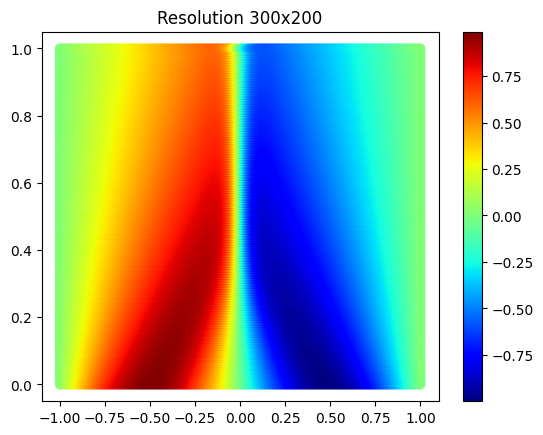

In [68]:
# perform prediction
u_grid_hat = model(torch.tensor(xt_grid, dtype=torch.float32)).detach()

# Create a figure with 1 row and 2 columns of subplots
fig, (ax1) = plt.subplots(1, 1)
# Left subplot - prediction
sc1 = ax1.scatter(xt_grid[:, 0:1], xt_grid[:, 1:], c=u_grid_hat, cmap='jet')
ax1.set_title(f'Resolution {Nx}x{Nt}')
fig.colorbar(sc1, ax=ax1)
plt.show()

In [69]:
def evaluate_residual_on_collocation_points(xt_grid, model, residual_pde_fn, batch_size=1024):
    """
    Evaluate residual_pde at each point in xt_grid using batching and original residual_pde function.
    
    Parameters:
        xt_grid (ndarray or tensor): shape (N, 2), with each row [x, t]
        model: the trained PINN model
        residual_pde_fn: original residual_pde function
        batch_size: number of points to evaluate per loop step
        
    Returns:
        residual_values: shape (N,) array of residuals
    """
    residual_values = []

    # Convert if necessary
    if isinstance(xt_grid, np.ndarray):
        xt_grid = torch.tensor(xt_grid, dtype=torch.float32)

    for i in range(0, len(xt_grid), batch_size):
        xt_batch = xt_grid[i:i+batch_size]

        batch_residuals = []
        for xt in xt_batch:
            r = residual_pde_fn(xt.unsqueeze(0), model)  # evaluate single point
            batch_residuals.append(r.item())

        residual_values.extend(batch_residuals)

    return np.array(residual_values)

In [70]:
residuals = evaluate_residual_on_collocation_points(xt_grid, model, residual_pde_fn=residual_pde)
residuals = residuals.reshape(T.shape)  # if xt_grid was created from meshgrid (X, T)

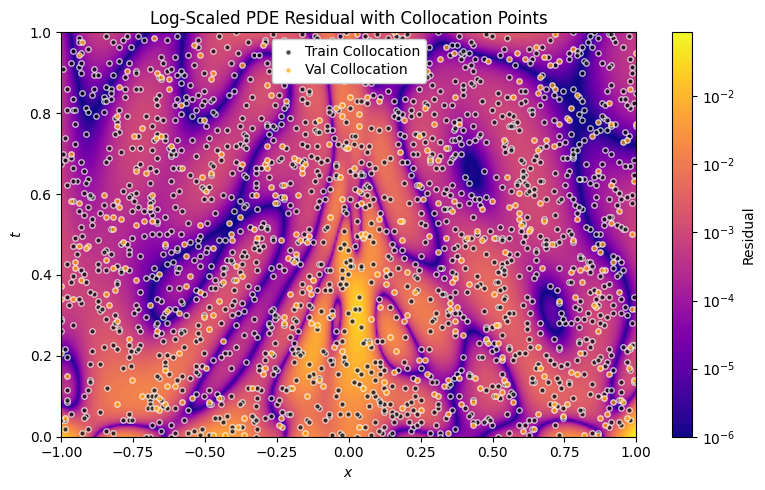

In [71]:
# Avoid log(0) by adding a small epsilon
epsilon = 1e-6
log_residuals = np.log10(residuals + epsilon)

plt.figure(figsize=(8, 5))

# Plot the log-scaled residual heatmap
contour = plt.contourf(X, T, log_residuals, levels=100, cmap='plasma')

# Add colorbar with custom tick labels
cbar = plt.colorbar(contour)
cbar.set_label('Residual')

# Set ticks (log scale) and format labels as actual residuals
log_ticks = np.linspace(np.floor(log_residuals.min()), np.floor(log_residuals.max()), 6)
cbar.set_ticks(log_ticks)
cbar.set_ticklabels([f"$10^{{{int(t)}}}$" for t in log_ticks])

# Overlay collocation points
plt.scatter(coll_points_train[:, 0], coll_points_train[:, 1], color='black', s=15, edgecolors='white', label='Train Collocation', alpha=0.7)
plt.scatter(coll_points_val[:, 0], coll_points_val[:, 1], color='orange', edgecolors='white',s=15, label='Val Collocation', alpha=0.7)

plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Log-Scaled PDE Residual with Collocation Points')
# Dense legend on the right
plt.legend(
    handlelength=1.5,
    handletextpad=0.5,
    labelspacing=0.3,
    fontsize='medium',
    framealpha=1.0
)
plt.tight_layout()
plt.show()

u_all shape: (200, 300)


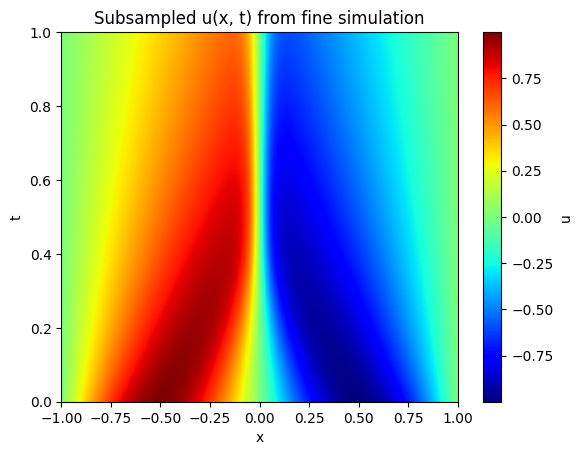

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Target resolution
x_target = np.linspace(-1, 1, Nx)
t_target = np.linspace(0, 1, Nt)

# Fine resolution for stability
Nx_fine = 1024
x_fine = np.linspace(-1, 1, Nx_fine)
dx = x_fine[1] - x_fine[0]

dt = 0.00001
Nt_fine = int(1.0 / dt)
save_times = np.linspace(0, Nt_fine-1, Nt, dtype=int)  # time indices to save

# Initialize fine grid
u = -np.sin(np.pi * x_fine)
u[0] = 0
u[-1] = 0

# Output array (Nt, Nx)
u_all = np.zeros((Nt, Nx))

# Save initial state (interpolated)
u_all[0] = np.interp(x_target, x_fine, u)

frame = 1
for n in range(1, Nt_fine):
    un = u.copy()
    u[1:-1] = (un[1:-1]
               - dt * un[1:-1] * (un[2:] - un[:-2]) / (2 * dx)
               + nu * dt * (un[2:] - 2 * un[1:-1] + un[:-2]) / dx**2)
    u[0] = 0
    u[-1] = 0

    if n == save_times[frame]:
        u_all[frame] = np.interp(x_target, x_fine, u)
        frame += 1
        if frame == Nt:
            break

# Final check
print("u_all shape:", u_all.shape)  # (100, 256)

# Optional: plot
plt.imshow(u_all, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Subsampled u(x, t) from fine simulation")
plt.colorbar(label='u')
plt.show()